# Wavelet Transform and Run-Length Encoding
## 1. Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pywt
from pywt import wavedec
import numpy as np
import pandas as pd
from scipy.signal import detrend
import copy 
import json
import os

## 2. Define constants

In [2]:
#define the sampling rate in Hz
FS = 32

#define the number of samples of data
#will be updated once data is read
NUM_SAMPLES = 100 

#define length of coefficient matrices
#values will be updated after wavelet decomposition
COEFF_LENGTHS1 = {'cA5': 100, 'cD5': 100, 'cD4': 100, 'cD3': 100, 'cD2': 100, 'cD1': 100}
COEFF_LENGTHS2 = {'cA5': 100, 'cD5': 100, 'cD4': 100, 'cD3': 100, 'cD2': 100, 'cD1': 100}
COEFF_LENGTHS3 = {'cA5': 100, 'cD5': 100, 'cD4': 100, 'cD3': 100, 'cD2': 100, 'cD1': 100}

#number of bits that can be used to represent the run length
#a 4 bit number corresponds to a max value of 2**4-1 = 15 bits or 32767.
#i.e. with NUM_BITS_RUN_LEN=4, we can represent, at maximum,
#a run of 32767 consecutive 0's or 1's
NUM_BITS_RUN_LEN = 4

#don't allow the PRD to be greater than 15
MAX_PRD = 10

#define the threshold percentage for retaining energy of wavelet coefficients
#separate percentage for approximate coefficients and separate for detailed
THRESH_PERC_APPROX = 0.9999
THRESH_PERC_D5 = 0.99
THRESH_PERC_D4_D1 = 0.99

## 3. Define functions  

### wavelet decomposition
*The wavelet used in this algorithm is bior4.4, with 5 levels of decomposition.*

In [3]:
def wavelet_decomposition(sig, do_plot):
    cA5, cD5, cD4, cD3, cD2, cD1 = wavedec(sig, 'bior4.4', level=5)
    coeffs = {'cA5': cA5, 'cD5': cD5, 'cD4': cD4, 'cD3': cD3, 'cD2': cD2, 'cD1': cD1}

    if do_plot:
        print('Plot of wavelet decomposition for all levels')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

    return coeffs

### wavelet reconstruction
*the wavelet is bior4.4 with 5 levels of decomposition*

In [4]:
def wavelet_reconstruction(coeffs, orig_data, CR, do_plot=False):
    reconstructed = pywt.waverec([coeffs['cA5'], coeffs['cD5'], coeffs['cD4'], coeffs['cD3'], 
                                    coeffs['cD2'], coeffs['cD1']], 'bior4.4')


    if do_plot:
        print('Plot of original signal through the process of compression and decompression:')
        
        t = [i/FS for i in range(NUM_SAMPLES)]
        plt.subplots(figsize=(16,9))
        plt.plot(t, orig_data, label='Original Signal')
        plt.plot(t, reconstructed, label='Reconstructed Signal')
        plt.title('Compression Ratio: %.1f' % CR)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.legend(loc=1)
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        #plt.savefig('figs/reconstructed.png', dpi=150)
        plt.show()

    return reconstructed

### threshold wavelet coefficients to a percentage of total energy
*Different levels of decomposition are thresholded at different energy percentages.*  
1. calculate the energy of all the coefficients
1. compute threshold for each coefficient matrix
1. keep corresponding coefficients that are above the threshold

In [5]:
def threshold_energy(coeffs, do_plot=False):
    #make a deep copy of coeffs to retain the original version
    coeffs_orig = copy.deepcopy(coeffs)

    binary_map = {}
    nonzero_coeff_count = {}

    for key in coeffs.keys():
        #sort the absolute value of the coefficients in descending order
        tmp_coeffs = np.sort(np.abs(coeffs[key]))[::-1]

        #calculate the threshold for retaining some percentage of the energy
        if key == 'cA5':
            thresh_perc = THRESH_PERC_APPROX
        elif key == 'cD5':
            thresh_perc = THRESH_PERC_D5
        else:
            thresh_perc = THRESH_PERC_D4_D1

        energy_thresholded = thresh_perc*energy(tmp_coeffs)
        energy_tmp = 0
        for coeff in tmp_coeffs:
            energy_tmp = energy_tmp + coeff**2

            if energy_tmp >= energy_thresholded:
                threshold = coeff
                break

        #set any coefficients below the threshold to zero
        tmp_coeffs = coeffs[key]
        inds_to_zero = np.where((tmp_coeffs < threshold) & (tmp_coeffs > -threshold))[0]
        tmp_coeffs[inds_to_zero] = 0

        #create the binary map
        binary_map_tmp = np.ones(len(coeffs[key])).astype(int)
        binary_map_tmp[inds_to_zero] = 0

        #update the various dictionaries
        coeffs[key] = tmp_coeffs
        binary_map[key] = binary_map_tmp
        nonzero_coeff_count[key] = len(tmp_coeffs)


    if do_plot:
        print('Plot of thresholded vs unthresholded coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Original')
        plt.plot(coeffs['cA5'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Original')
        plt.plot(coeffs['cD5'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Original')
        plt.plot(coeffs['cD4'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Original')
        plt.plot(coeffs['cD3'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Original')
        plt.plot(coeffs['cD2'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Original')
        plt.plot(coeffs['cD1'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

        
    return coeffs, binary_map, coeffs_orig

### scale the wavelet coefficients to the [0,1] range
*two scaling factors: a shift factor and a multiplication factor*

In [6]:
def scale_coeffs(coeffs, do_plot=False):
    coeffs_scaled = {}
    scaling_factors = {}

    for key in coeffs.keys():
        shift_factor = np.min(coeffs[key])
        coeffs_tmp = coeffs[key]-shift_factor

        scale_factor = np.max(coeffs_tmp)
        coeffs_tmp = coeffs_tmp/scale_factor

        scaling_factors[key] = {'shift_factor': shift_factor, 'scale_factor': scale_factor}
        coeffs_scaled[key] = coeffs_tmp


    if do_plot:
        print('Plot of scaled coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_scaled['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_scaled['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_scaled['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_scaled['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_scaled['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_scaled['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

    return coeffs_scaled, scaling_factors

### unscale the coefficients back to their original scaling

In [7]:
def unscale_coeffs(coeffs_orig, coeffs_reconstructed, scaling_factors, bits, do_plot=False):
    coeffs_unscaled = {}

    for key in coeffs_reconstructed.keys():
        tmp_coeffs_unscaled = coeffs_reconstructed[key]/(2**bits)
        tmp_coeffs_unscaled = tmp_coeffs_unscaled*scaling_factors[key]['scale_factor']
        tmp_coeffs_unscaled = tmp_coeffs_unscaled + scaling_factors[key]['shift_factor']

        #now replace the NaN values with 0
        nan_inds = np.where(np.isnan(tmp_coeffs_unscaled))[0]
        tmp_coeffs_unscaled[nan_inds] = 0

        coeffs_unscaled[key] = tmp_coeffs_unscaled


    if do_plot:
        print('Plot of wavelet coefficients before scaling and after rescaling:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cA5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD4'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD3'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD2'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD1'], label='After Rescaling')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

    return coeffs_unscaled

### calculate the lowest possible number of bits to quantize the wavelet coefficients such that the PRD is above the threshold
1. quantize the signal starting at 8 bits
1. unquantize and reconstruct the signal
1. calculate the PRD. Repeat with 1 fewer bit (ie, 7 bits)
1. repeat

In [8]:
def calculate_num_bits(orig_sig, coeffs_scaled, binary_map, scaling_factors, do_plot=False):
    #starting at 8 bits, keep decreasing the number of bits in the quantization
    #until the PRD is above some threshold
    num_bits = 9

    #initialize PRD to 0 so the while loop can run
    PRD = 0

    #keep track of PRD per number of bits
    PRD_dict = {}

    if do_plot:
        plt.subplots(figsize=(16,9))
        t = [i/FS for i in range(NUM_SAMPLES)]
        plt.plot(t, orig_sig, label='Original Signal')


    while (num_bits >= 5) and (PRD <= MAX_PRD):
        #decrement the number of bits
        num_bits = num_bits-1

        coeffs_quantized = do_quantization(coeffs_scaled, num_bits)

        #rescale the coefficients
        coeffs_unscaled = unscale_coeffs(None, coeffs_quantized, scaling_factors, num_bits)

        #do the inverse dwt
        data_reconstructed = wavelet_reconstruction(coeffs_unscaled, None, None)

        #calculate PRD
        PRD = calculate_PRD(orig_sig, data_reconstructed)
        PRD_dict[num_bits] = PRD

        #plot the reconstructed signals 
        if do_plot:
            if PRD <= MAX_PRD:
                plt.plot(t, data_reconstructed, label='Reconstructed @ %i Bits, PRD = %.2f' % (num_bits, PRD))

    #if we went over the PRD, go back up by one bit
    if PRD > MAX_PRD:
        num_bits = num_bits+1
        PRD = PRD_dict[num_bits]

    #plot some more stuff
    if do_plot:
        print('Plots of reconstructed signals vs number of bits used for quantization:')
        plt.legend(loc=1)
        plt.tight_layout()
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.show()


    return num_bits, PRD

### combine all the wavelet coefficients into one continuous array
*done for each decomposition level and for binary map*

In [9]:
def combine_coefficients(coeffs, binary_map=None):
    coeffs_combined = []

    #loop through each of the wavelet decompositions
    #(or coefficient matrices) and remove all zero values
    #based on the binary map
    if binary_map is not None:
        for key in coeffs.keys():
            inds_to_keep = np.where(binary_map[key]==1)[0]
            coeffs[key] = coeffs[key][inds_to_keep]

    #add each array to coeffs_combined
    coeffs_combined.extend(coeffs['cA5'])
    coeffs_combined.extend(coeffs['cD5'])
    coeffs_combined.extend(coeffs['cD4'])
    coeffs_combined.extend(coeffs['cD3'])
    coeffs_combined.extend(coeffs['cD2'])
    coeffs_combined.extend(coeffs['cD1'])

    return coeffs_combined

### map the wavelet coefficients (and the binary map) back to their original decomposition levels
*necessary prerequisite for reconstruction of the time domain waveform*

In [10]:
def remap_coeffs(coeffs, binary_map, COEFF_LENGTHS):
    coeffs_remapped = np.zeros(len(binary_map))*np.nan
    inds_to_set = np.where(np.asarray(binary_map)==1)[0]
    coeffs_remapped[inds_to_set] = coeffs

    wavelet_remapped = {}
    counter = 0
    wavelet_remapped['cA5'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cA5']]

    counter = counter + COEFF_LENGTHS['cA5']
    wavelet_remapped['cD5'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD5']]

    counter = counter + COEFF_LENGTHS['cD5']
    wavelet_remapped['cD4'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD4']]

    counter = counter + COEFF_LENGTHS['cD4']
    wavelet_remapped['cD3'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD3']]

    counter = counter + COEFF_LENGTHS['cD3']
    wavelet_remapped['cD2'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD2']]

    counter = counter + COEFF_LENGTHS['cD2']
    wavelet_remapped['cD1'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD1']]

    return wavelet_remapped

### quantization
*input: the selected largest wavelet coefficients*  

In [11]:
def do_quantization(coeffs, bits, do_plot=False):
    quantized_coeffs = {}

    for key in coeffs.keys():
        sig = coeffs[key]
        sig = sig*(2**bits-1)
        sig = np.round(sig)
        sig = np.array(sig).astype(int)

        quantized_coeffs[key] = sig


    if do_plot:
        print('Plot of quantized coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(quantized_coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(quantized_coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(quantized_coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(quantized_coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(quantized_coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(quantized_coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

        
    return quantized_coeffs

### compress the wavelet coefficients
*combine bits into bytes*

In [12]:
def compress_coefficients(coeffs, num_bits):

    binary_string = ''

    for coeff in coeffs:
        #convert each coefficient value to binary in num_bits number of bits
        binary_string = binary_string + format(coeff, '0%ib' % num_bits)

    #loop through sets of 8 bits in the binary string and convert to a byte
    byte_array = []
    for i in range(int(len(binary_string)/8)):
        byte_tmp = binary_string[i*8:(i+1)*8]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)

    #check if there are any remaining bits that don't divide evenly into 8
    #note the number of bits in this last byte for conversion back to int
    #later on
    num_bits_last_byte = 8
    if len(binary_string)%8 != 0:
        byte_tmp = binary_string[(i+1)*8:(i+1)*8 + len(binary_string)%8]
        num_bits_last_byte = len(byte_tmp)
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)

    return byte_array, num_bits_last_byte

### decompress the previously compressed wavelet coefficients

In [13]:
def decompress_coefficients(coeffs_compressed, num_bits, num_bits_last_byte):

    binary_string = ''

    #convert each coefficient value to binary in 8 number of bits
    #note that the very last value in the the binary map may not be
    #a full 8 bits. so convert that based on num_bits_last_byte
    coeffs_len = len(coeffs_compressed)
    for i in range(coeffs_len):
        if i == coeffs_len-1:
            binary_string = binary_string + format(coeffs_compressed[i], '0%ib' % num_bits_last_byte)
        else:
            binary_string = binary_string + format(coeffs_compressed[i], '08b')


    #loop through sets of num_bits bits in the binary string and convert to a byte
    byte_array = []
    for i in range(int(len(binary_string)/num_bits)):
        byte_tmp = binary_string[i*num_bits:(i+1)*num_bits]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    return byte_array

### compress the binary map using variable length run-length encoding (RLE)

In [14]:
def compress_binary_map(binary_map):
    #define a state machine that loops through each entry in the binary map and 
    #creates the compressed representation. 

    #the last run count won't be included in the compressed representation, so 
    #just append one more value at the end of the binary map to trigger the last 
    #compression value. make a local deep copy so that the original is not affected
    binary_map = copy.deepcopy(binary_map)
    binary_map.append(int(not binary_map[-1]))


    CURRENT_STATE = binary_map[0]
    run_count = 0
    binary_string = ''

    #loop through each value in the binary map
    for val in binary_map:

        #if the current binary map value is the same as the previous one, just increment the run count
        if val == CURRENT_STATE:
            run_count = run_count + 1

        #otherwise, encode the current run count 
        else:

            #handle cases where run count <= 3
            if run_count == 1:
                binary_string_tmp = '00'

            elif run_count == 2:
                binary_string_tmp = '01'

            elif run_count == 3:
                binary_string_tmp = '10'

            #otherwise, if the run count > 3
            else:
                #calculate the number bits required to represent the run count
                num_bits_run_count = len(format(run_count, 'b'))

                #build a binary string
                binary_string_tmp = ''

                #first bit represents that the run count > 3
                binary_string_tmp = binary_string_tmp + '11'

                #next 4 bits represent the number of bits that will define the run count
                binary_string_tmp = binary_string_tmp + format(num_bits_run_count, '0%ib' % NUM_BITS_RUN_LEN)

                #next number of bits is variable, and is the actual run count
                #may be up to 15 bits assuming NUM_BITS_RUN_LEN=4
                binary_string_tmp = binary_string_tmp + format(run_count, 'b')

            #print(str(run_count) + ', ' + binary_string_tmp)
            #pdb.set_trace()

            #append the binary string
            binary_string = binary_string + binary_string_tmp

            #reset the run count 
            run_count = 1

        #update the current state
        CURRENT_STATE = val


    #convert the binary string into a buffer of 8 bit bytes 
    byte_array = []
    for i in range(int(len(binary_string)/8)):
        byte_tmp = binary_string[i*8:(i+1)*8]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #check if there are any remaining bits that don't divide evenly into 8
    num_bits_last_byte = 8
    if len(binary_string)%8 != 0:
        byte_tmp = binary_string[(i+1)*8:(i+1)*8 + len(binary_string)%8]
        num_bits_last_byte = len(byte_tmp)
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #return the initial state (ie, the first value in binary map), and the RLE binary map
    return binary_map[0], byte_array, num_bits_last_byte

### decompress the previously compressed binary map

In [15]:
def decompress_binary_map(binary_map_compressed, binary_map_initial_state, num_bits_last_byte):

    #first convert 8 bit numbers into a binary string
    binary_string = ''

    #convert each coefficient value to binary in 8 number of bits
    #note that the very last value in the the binary map may not be
    #a full 8 bits. so convert that based on num_bits_last_byte
    binary_map_len = len(binary_map_compressed)
    for i in range(binary_map_len):
        if i == binary_map_len-1:
            binary_string = binary_string + format(binary_map_compressed[i], '0%ib' % num_bits_last_byte)
        else:
            binary_string = binary_string + format(binary_map_compressed[i], '08b')


    #define a state machine that loops through each entry in the binary map and 
    #creates the uncompressed representation. 
    READ_HEADER = 0
    READ_NUM_BITS = 1
    READ_RUN_LEN = 2
    state = READ_HEADER

    run_type = binary_map_initial_state
    header = ''
    binary_array = np.array([])


    #loop through each value in the binary map
    for val in binary_string:

        #read the header
        if state == READ_HEADER:
            header = header + val

            if len(header) == 2:
                #run count 1
                if header == '00':
                    binary_array = np.concatenate((binary_array, np.ones(1)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 2
                if header == '01':
                    binary_array = np.concatenate((binary_array, np.ones(2)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 3
                if header == '10':
                    binary_array = np.concatenate((binary_array, np.ones(3)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count > 3
                if header == '11':
                    state = READ_NUM_BITS
                    num_bits = ''


                #reset header 
                header = ''

            continue

        #read number of bits
        if state == READ_NUM_BITS:


            num_bits = num_bits + val

            if len(num_bits) == 4:
                num_bits_run_len = int(num_bits, 2)
                run_len = ''

                state = READ_RUN_LEN

            continue


        #read run length
        if state == READ_RUN_LEN:
            run_len = run_len + val

            if len(run_len) == num_bits_run_len:
                run_len = int(run_len, 2)
                binary_array = np.concatenate((binary_array, np.ones(run_len)*run_type))
                run_type = int(not run_type)
                state = READ_HEADER

            continue


    return binary_array

### calculate signal energy

In [16]:
def energy(sig):
    return np.sum(sig**2)

### calculate the percentage root-mean-square difference (PRD)

In [17]:
def calculate_PRD(orig_sig, reconstructed_sig):
    num = np.sum((orig_sig - reconstructed_sig)**2)
    den = np.sum(orig_sig**2)

    PRD = np.sqrt(num/den)*100

    return PRD

### plot difference between original and reconstructed signal

In [18]:
def plot_diff(orig_sig, reconstructed_sig):
    print('Plot of difference between original and reconstructed signal:')
        
    t = [i/FS for i in range(len(orig_sig))]
    plt.subplots(figsize=(16,9))
    plt.plot(t, orig_sig-reconstructed_sig, label='Difference')
    plt.title('Original Signal - Reconstructed Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.legend(loc=1)
    axes = plt.gca()
    axes.set_xlim((17, 21.5))
    plt.show()

## Compression Procedure
### load data
#### *note: data has been preprocessed as shown in Baiying's code_m1.ipynb*

In [19]:
data1 = np.loadtxt(fname = 'processed_acc_col1.txt')
data2 = np.loadtxt(fname = 'processed_acc_col2.txt')
data3 = np.loadtxt(fname = 'processed_acc_col3.txt')

In [20]:
NUM_SAMPLES = len(data1)

(30000, 32000)

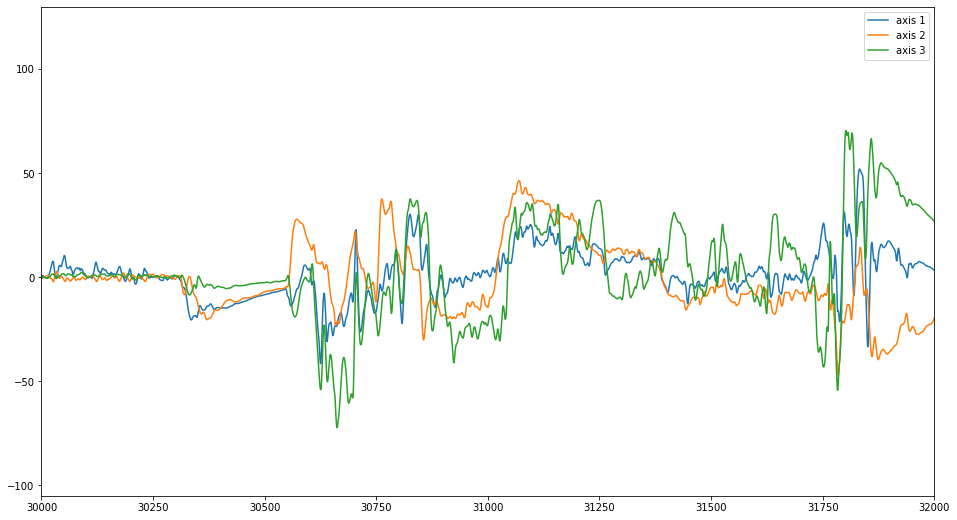

In [21]:
plt.subplots(figsize=(16,9))
plt.plot(data1, label='axis 1')
plt.plot(data2, label='axis 2')
plt.plot(data3, label='axis 3')
plt.legend(loc=1)
plt.xlim(30000,32000)

In [22]:
#create plots parameter
do_plot = True

### perform wavelet decomposition
input: array *data*  
decomposition level: *5*  
wavelet used: *bior4.4*

Plot of wavelet decomposition for all levels


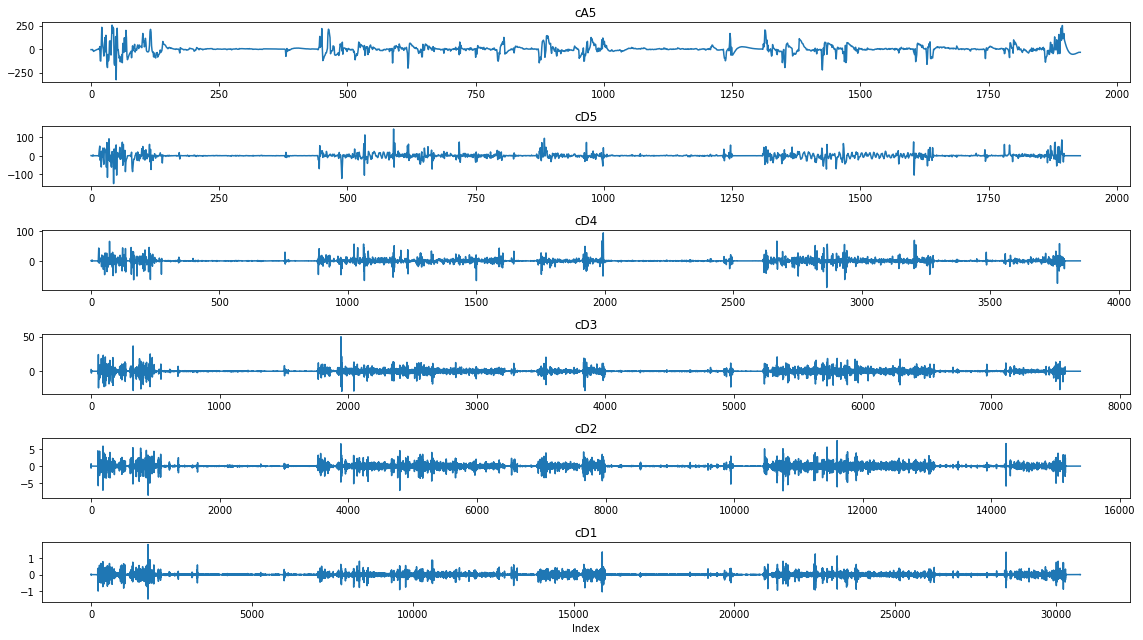

Plot of wavelet decomposition for all levels


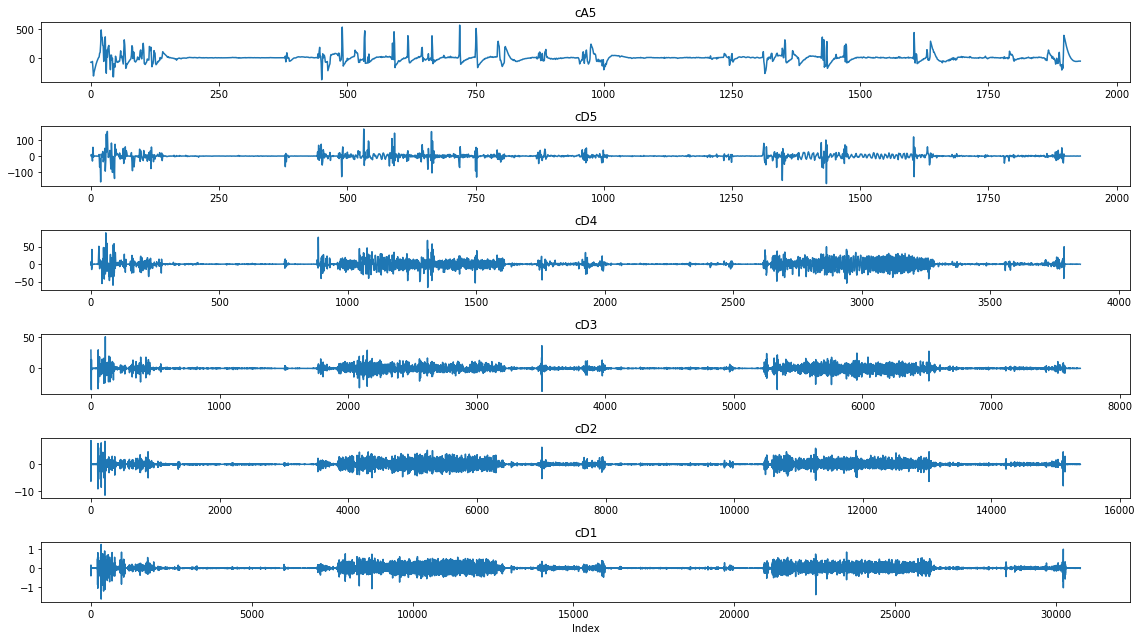

Plot of wavelet decomposition for all levels


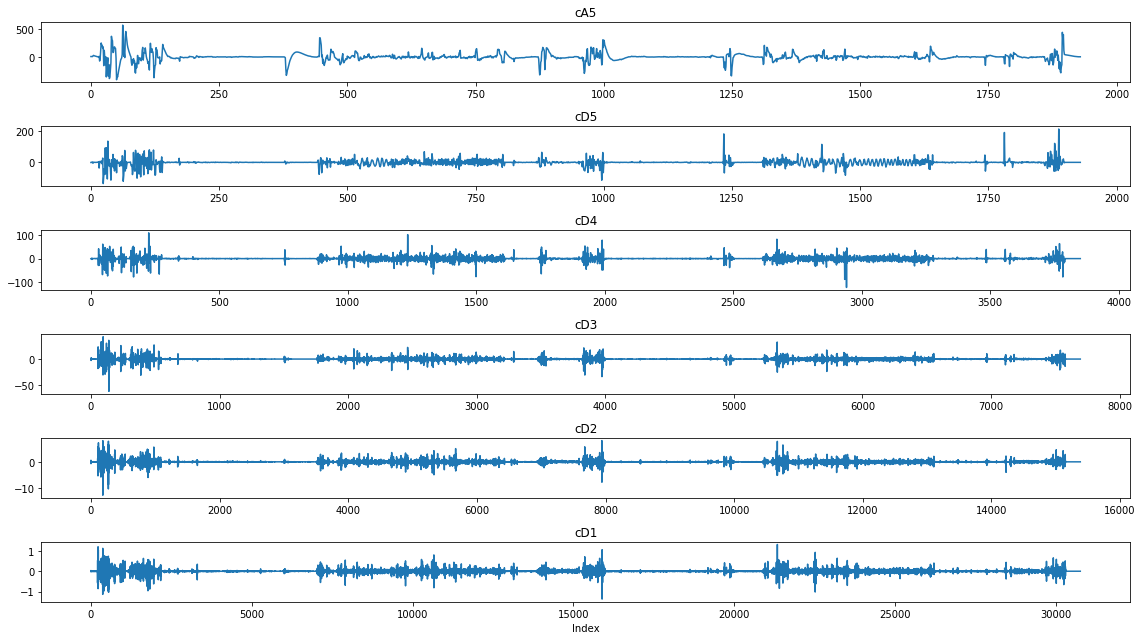

In [23]:
coeffs1 = wavelet_decomposition(data1,do_plot)
coeffs2 = wavelet_decomposition(data2,do_plot)
coeffs3 = wavelet_decomposition(data3,do_plot)

In [24]:
#update coefficient matrix lengths
for key in coeffs1.keys():
    COEFF_LENGTHS1[key] = len(coeffs1[key])
for key in coeffs2.keys():
    COEFF_LENGTHS2[key] = len(coeffs2[key])
for key in coeffs3.keys():
    COEFF_LENGTHS3[key] = len(coeffs3[key])

print(COEFF_LENGTHS1)
print(COEFF_LENGTHS2)
print(COEFF_LENGTHS3)

{'cA5': 1930, 'cD5': 1930, 'cD4': 3852, 'cD3': 7695, 'cD2': 15382, 'cD1': 30756}
{'cA5': 1930, 'cD5': 1930, 'cD4': 3852, 'cD3': 7695, 'cD2': 15382, 'cD1': 30756}
{'cA5': 1930, 'cD5': 1930, 'cD4': 3852, 'cD3': 7695, 'cD2': 15382, 'cD1': 30756}


### threshold coefficients
Different levels of decomposition are thresholded at different energy percentages.
1. Calculate the energy of all the coefficients.
1. Sort the coefficients from highest to lowest.
1. Calculate the energy as each new coefficient is added.
1. Repeat until the percentage is above the threshold.

Plot of thresholded vs unthresholded coefficients:


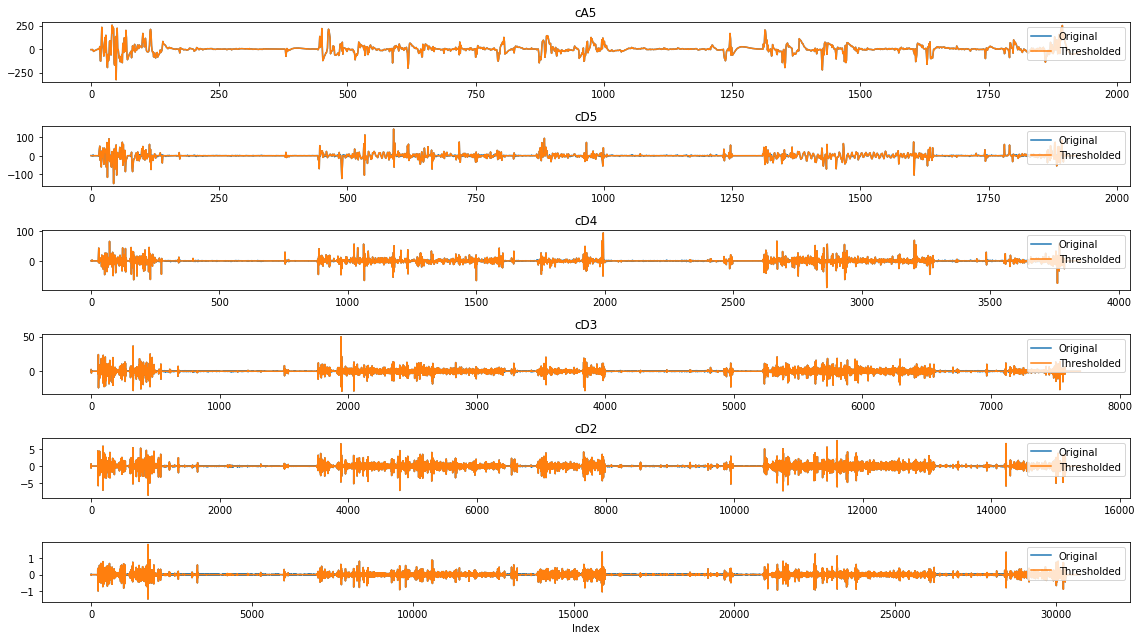

Plot of thresholded vs unthresholded coefficients:


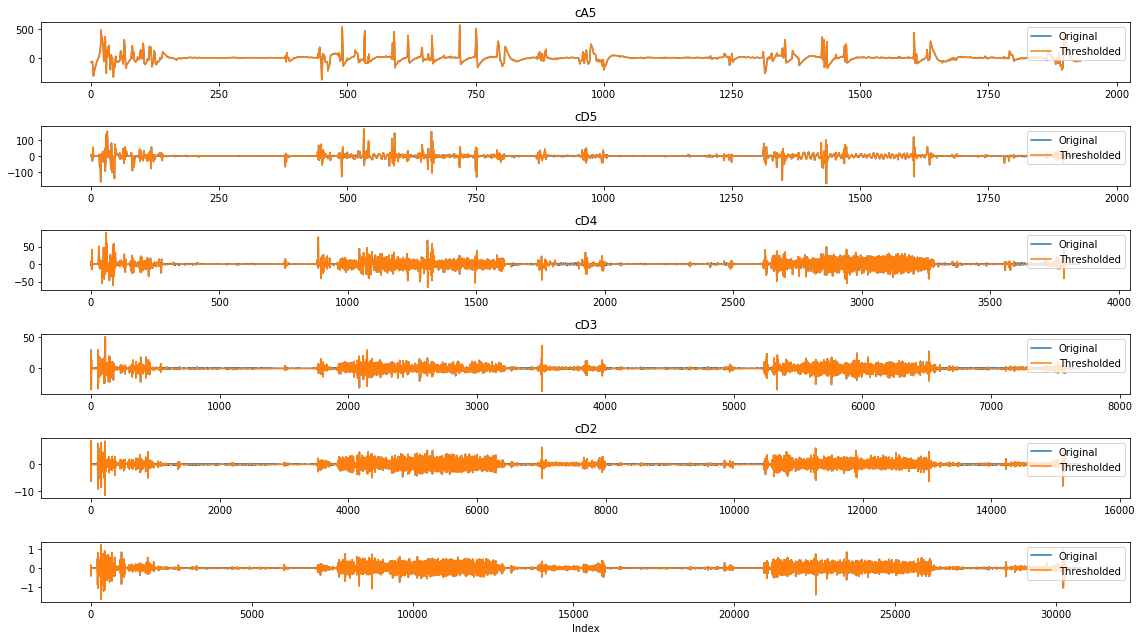

Plot of thresholded vs unthresholded coefficients:


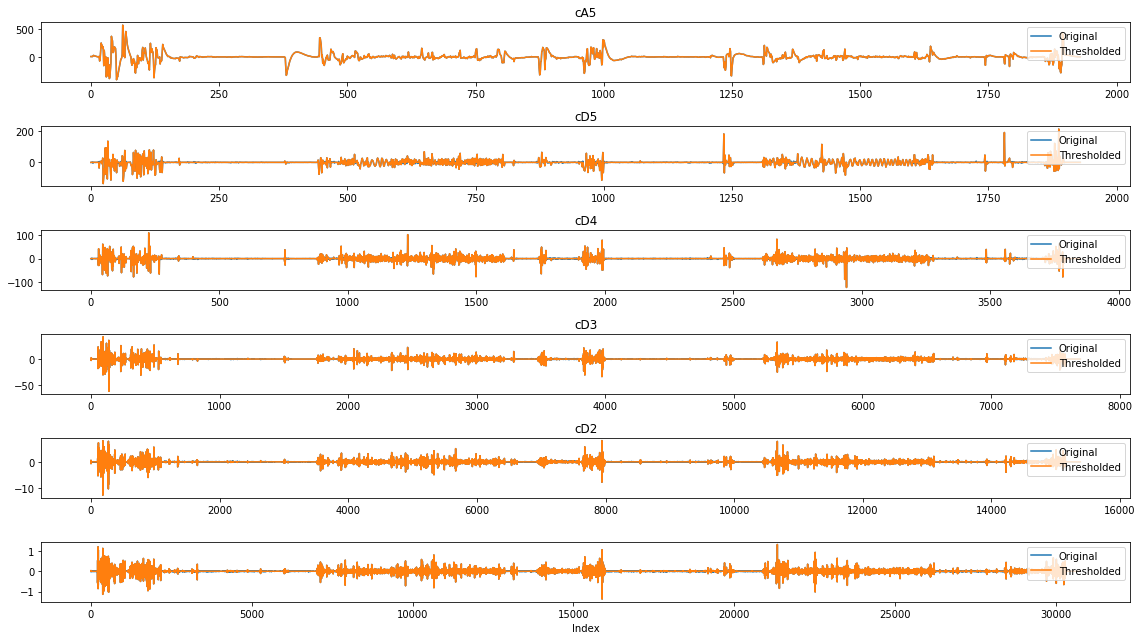

In [25]:
coeffs_thresholded1, binary_map1, coeffs_orig1 = threshold_energy(coeffs1, do_plot)
coeffs_thresholded2, binary_map2, coeffs_orig2 = threshold_energy(coeffs2, do_plot)
coeffs_thresholded3, binary_map3, coeffs_orig3 = threshold_energy(coeffs3, do_plot)

(1000, 1200)

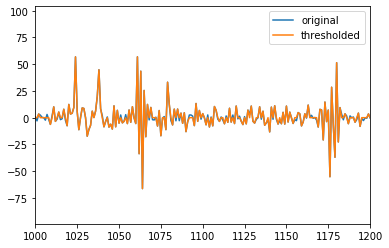

In [26]:
plt.plot(coeffs_orig1['cD4'], label = 'original')
plt.plot(coeffs_thresholded1['cD4'], label = 'thresholded')
plt.legend(loc=1)
plt.xlim(1000,1200)

### scale coefficients to the [0,1] range
at each decomposition level:
1. shift values by the minimum value
1. divide values by the maximum value

Plot of scaled coefficients:


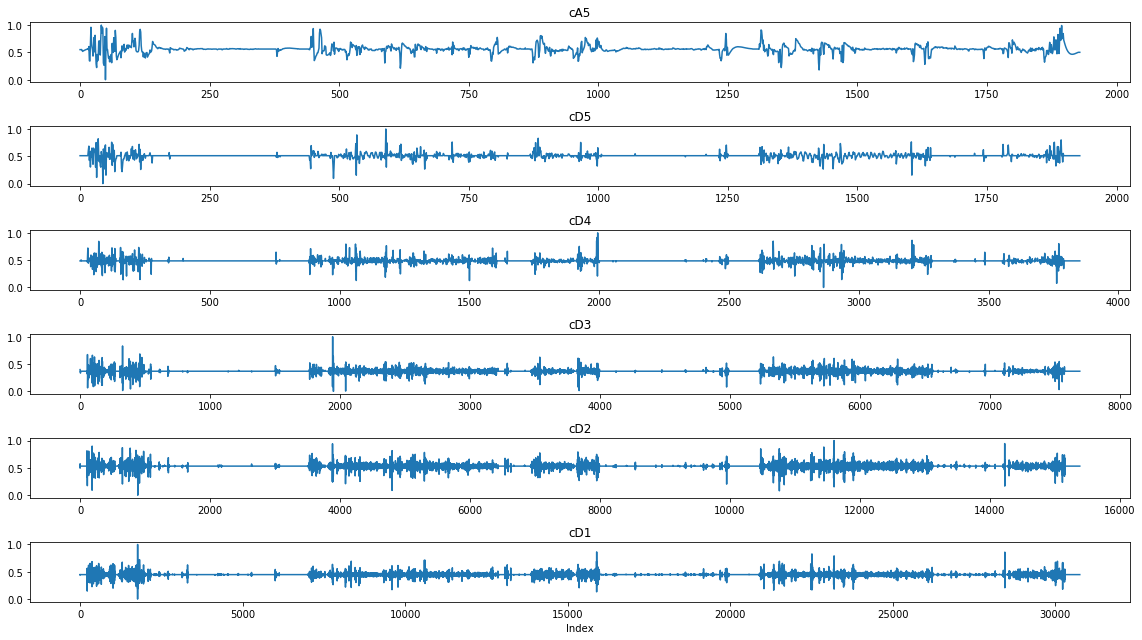

Plot of scaled coefficients:


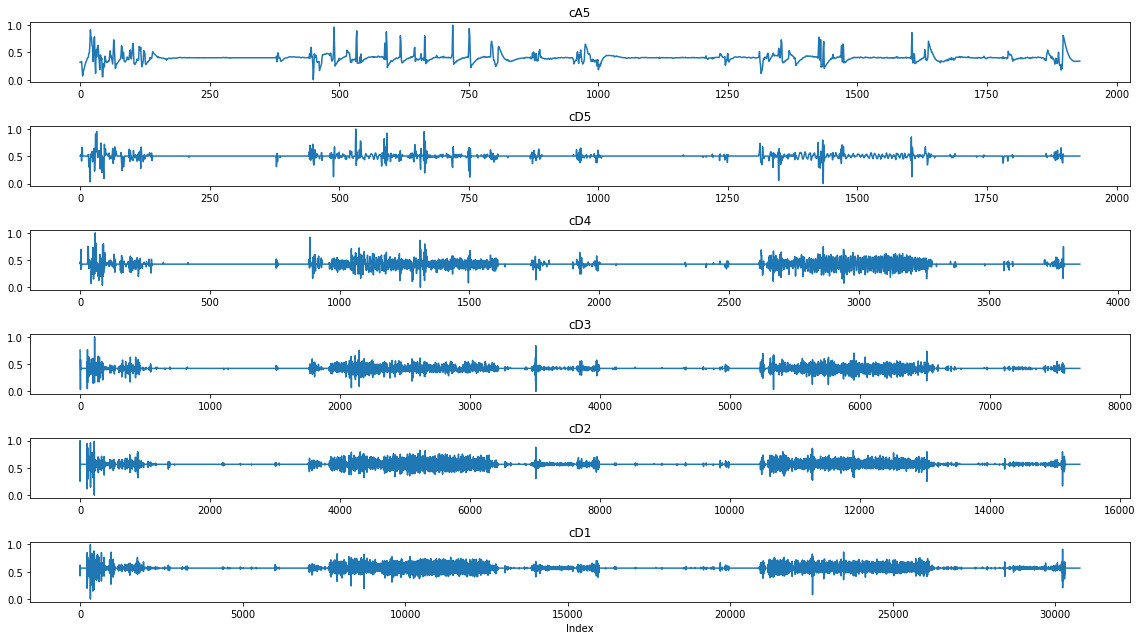

Plot of scaled coefficients:


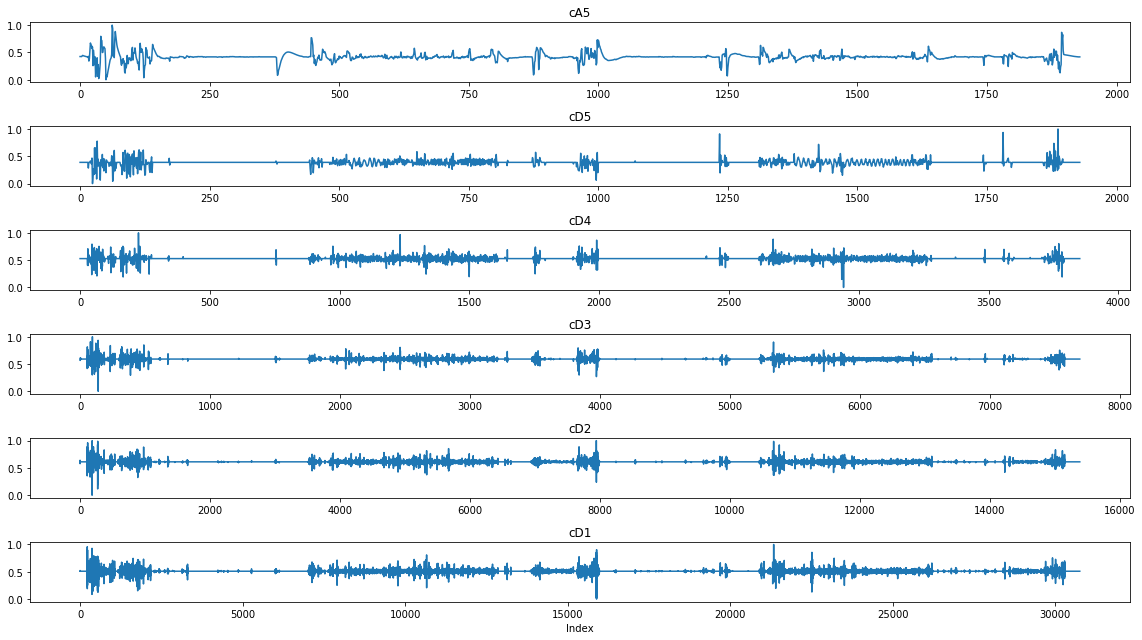

In [27]:
coeffs_scaled1, scaling_factors1 = scale_coeffs(coeffs_thresholded1, do_plot)
coeffs_scaled2, scaling_factors2 = scale_coeffs(coeffs_thresholded2, do_plot)
coeffs_scaled3, scaling_factors3 = scale_coeffs(coeffs_thresholded3, do_plot)

### calculate minimum number of bits required to achieve desired PRD
1. Quantize the signal starting at 8 bits
1. Unquantize and reconstruct the signal
1. Calculate the PRD
1. Repeat with 1 fewer bit (ie, 7 bits), ...

Plots of reconstructed signals vs number of bits used for quantization:


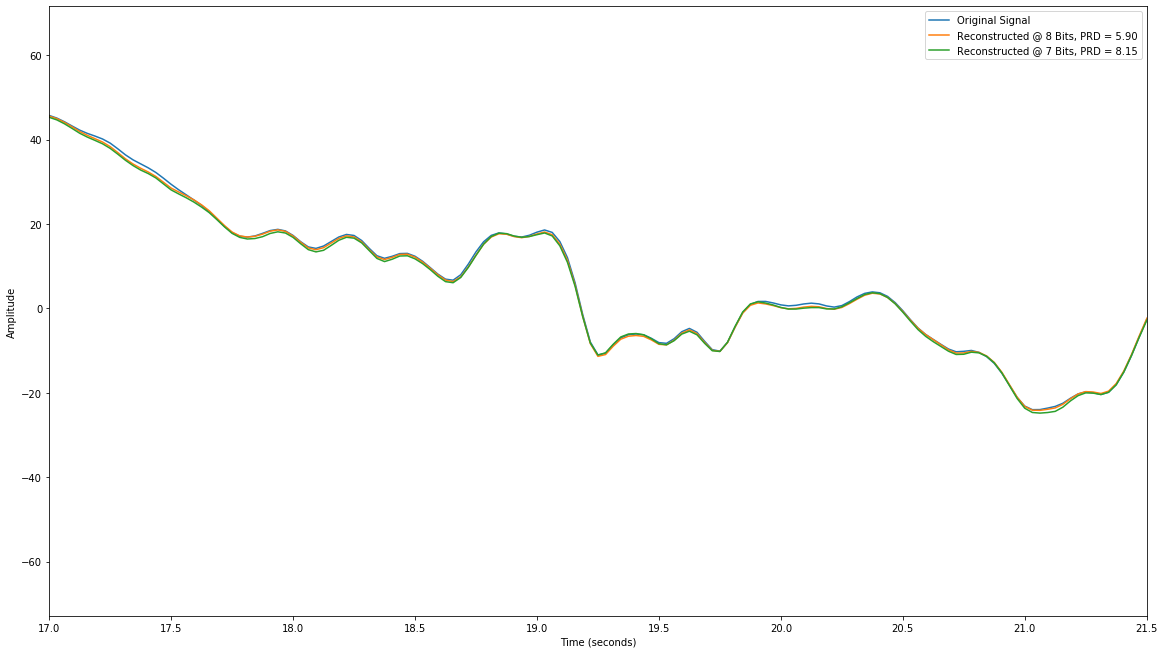

Plots of reconstructed signals vs number of bits used for quantization:


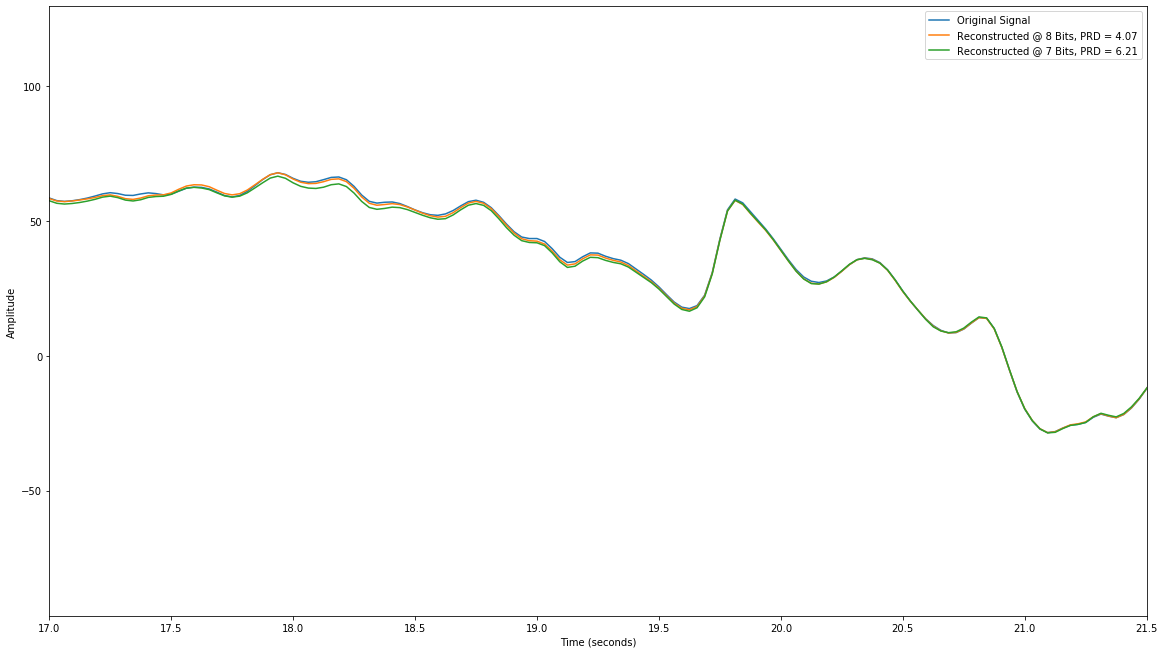

Plots of reconstructed signals vs number of bits used for quantization:


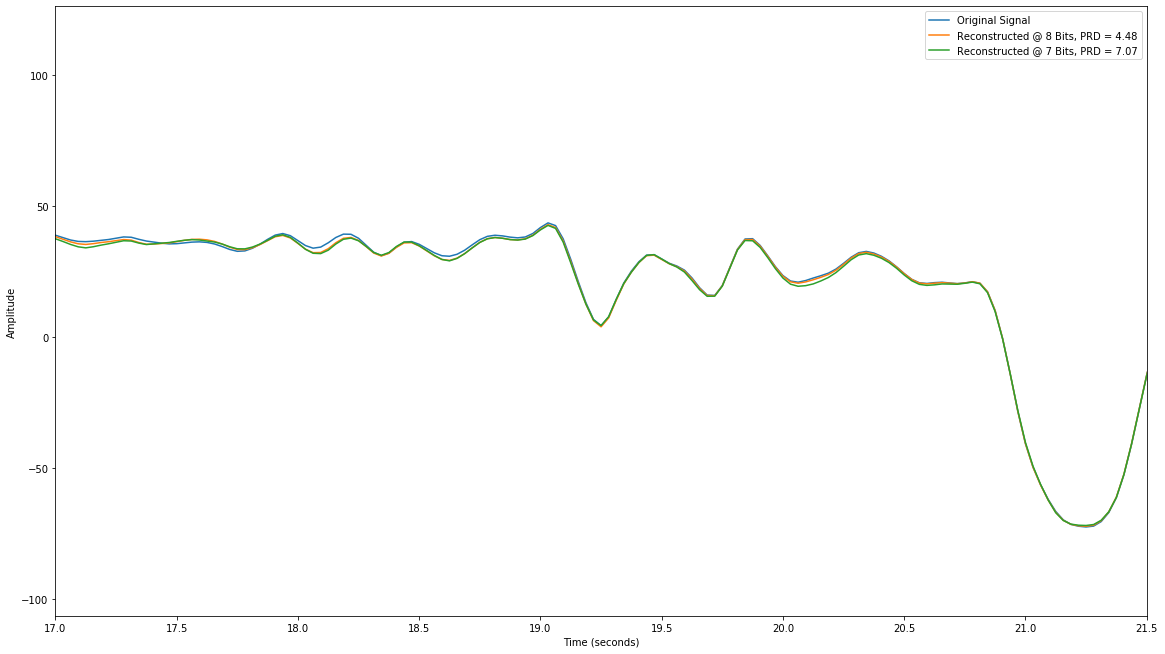

In [28]:
num_bits1, PRD1 = calculate_num_bits(data1, coeffs_scaled1, binary_map1, scaling_factors1, do_plot)
num_bits2, PRD2 = calculate_num_bits(data2, coeffs_scaled2, binary_map2, scaling_factors2, do_plot)
num_bits3, PRD3 = calculate_num_bits(data3, coeffs_scaled3, binary_map3, scaling_factors3, do_plot)

In [29]:
g = globals()
for i in range(1,4):
    nb_name = 'num_bits{}'.format(i)
    prd_name = 'PRD{}'.format(i)
    print('number of bits: %d' % g[nb_name])
    print('PRD: %.3f \n' % g[prd_name])

number of bits: 7
PRD: 8.154 

number of bits: 7
PRD: 6.212 

number of bits: 7
PRD: 7.072 



### quantize coefficients
1. Take in the scaled wavelet coefficients
1. Multiply by 2^(num_bits)
1. Round to the nearest integer.

Plot of quantized coefficients:


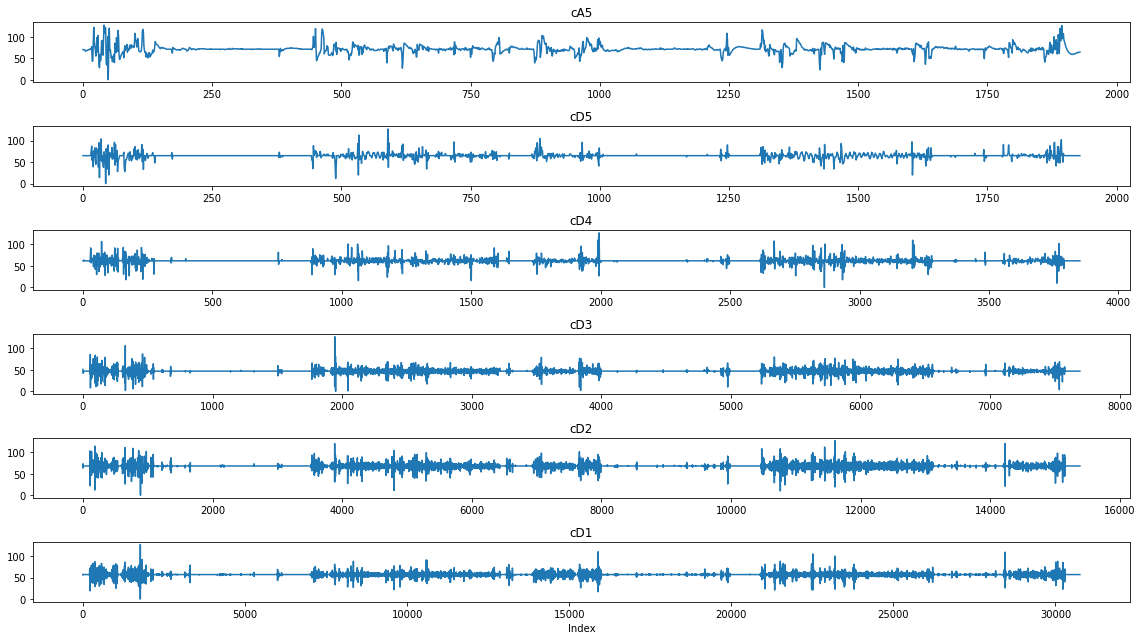

Plot of quantized coefficients:


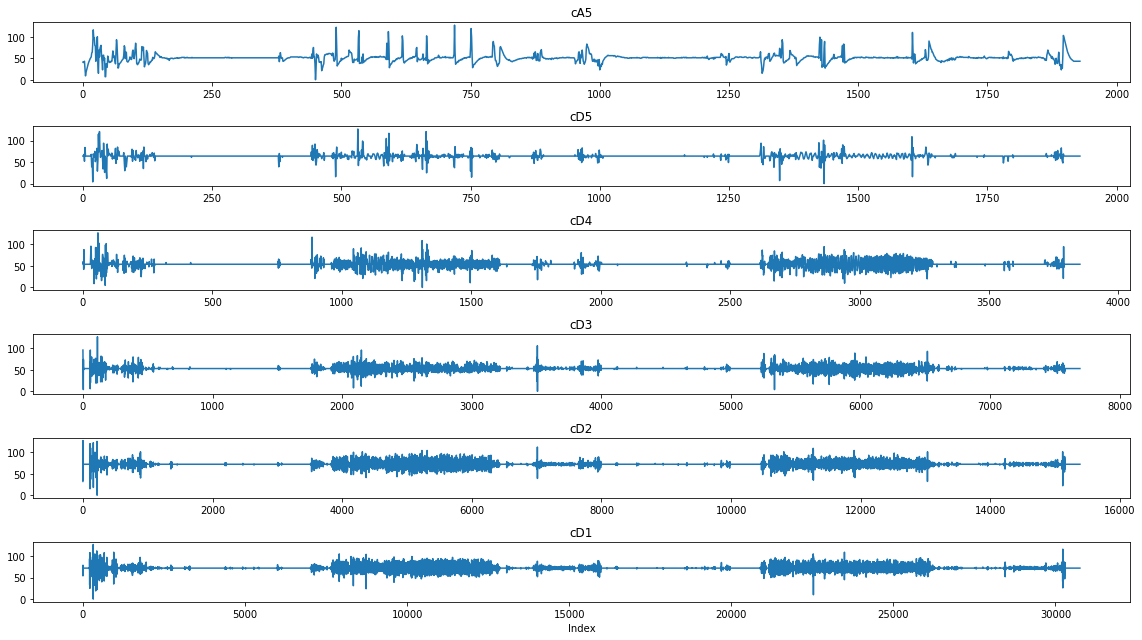

Plot of quantized coefficients:


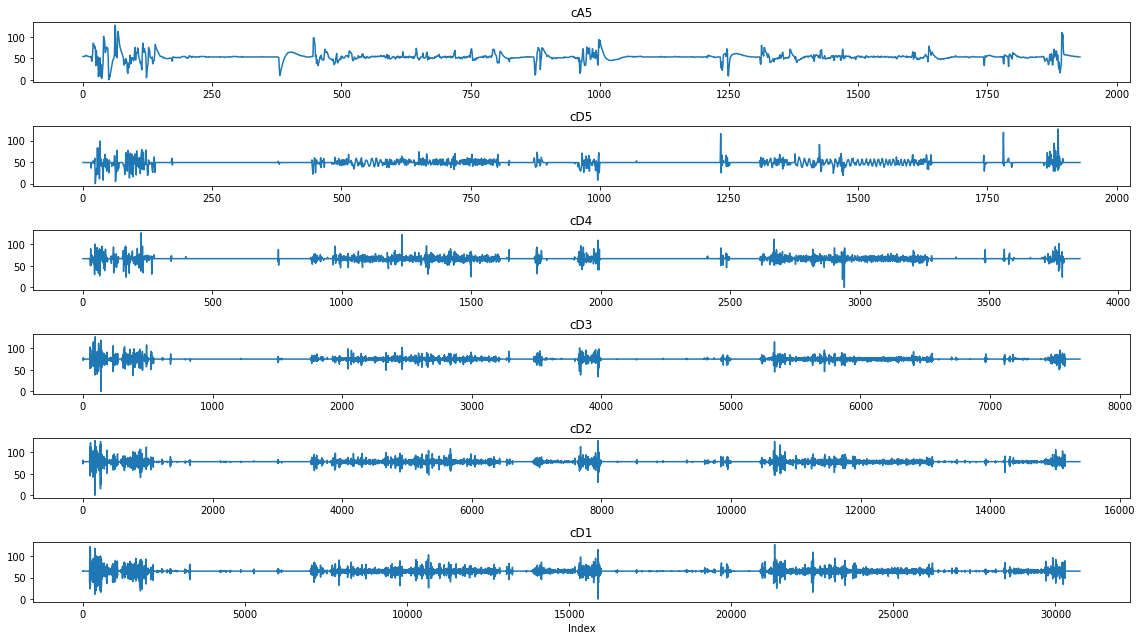

In [30]:
coeffs_quantized1 = do_quantization(coeffs_scaled1, num_bits1, do_plot)
coeffs_quantized2 = do_quantization(coeffs_scaled2, num_bits2, do_plot)
coeffs_quantized3 = do_quantization(coeffs_scaled3, num_bits3, do_plot)

### combine all coefficient arrays into one array
prior to this step, wavelet coefficients are separated by decomposition level

In [31]:
coeffs_quantized_combined1 = combine_coefficients(coeffs_quantized1, binary_map1)
coeffs_quantized_combined2 = combine_coefficients(coeffs_quantized2, binary_map2)
coeffs_quantized_combined3 = combine_coefficients(coeffs_quantized3, binary_map3)

### combine all binary maps into a single array
prior to this step, binary maps are separated by decomposition level

In [32]:
binary_map_combined1 = combine_coefficients(binary_map1)
binary_map_combined2 = combine_coefficients(binary_map2)
binary_map_combined3 = combine_coefficients(binary_map3)

### compress coefficients
each quantized coefficient can be represented by num_bits = 4 bits  
the wavelet coefficients are compressed using simple bit packing

In [33]:
coeffs_quantized_compressed1, num_bits_last_byte_coeffs1 = compress_coefficients(coeffs_quantized_combined1, num_bits1)
coeffs_quantized_compressed2, num_bits_last_byte_coeffs2 = compress_coefficients(coeffs_quantized_combined2, num_bits2)
coeffs_quantized_compressed3, num_bits_last_byte_coeffs3 = compress_coefficients(coeffs_quantized_combined3, num_bits3)

In [34]:
print(len(coeffs_quantized_combined1)/len(coeffs_quantized_compressed1))
print(len(coeffs_quantized_combined2)/len(coeffs_quantized_compressed2))
print(len(coeffs_quantized_combined3)/len(coeffs_quantized_compressed3))

1.1428571428571428
1.142849796883838
1.142819692759398


### compress binary map
compressed using variable run-length encoding

In [35]:
binary_map_initial_state1, binary_map_compressed1, num_bits_last_byte_binary_map1 = compress_binary_map(binary_map_combined1)
binary_map_initial_state2, binary_map_compressed2, num_bits_last_byte_binary_map2 = compress_binary_map(binary_map_combined2)
binary_map_initial_state3, binary_map_compressed3, num_bits_last_byte_binary_map3 = compress_binary_map(binary_map_combined3)

In [36]:
print(len(binary_map_combined1)/len(binary_map_compressed1))
print(len(binary_map_combined2)/len(binary_map_compressed2))
print(len(binary_map_combined3)/len(binary_map_compressed3))

9.607399313143928
10.613036730470771
10.149241424802112


### save coefficients and binary map as txt files
arrays are saved using the savetxt method from numpy  
integers are saved using the built-in file write function  
the scaling factors dictionary is saved using the dump method from json

In [37]:
os.mkdir('compressed_acc')

In [38]:
np.savetxt('compressed_acc/acc_cqc1.txt',coeffs_quantized_compressed1,fmt='%3d') 
np.savetxt('compressed_acc/acc_cqc2.txt',coeffs_quantized_compressed2,fmt='%3d') 
np.savetxt('compressed_acc/acc_cqc3.txt',coeffs_quantized_compressed3,fmt='%3d') 

In [39]:
with open('compressed_acc/acc_nblbc1.txt','w') as f:
    f.write('%d' % num_bits_last_byte_coeffs1)
with open('compressed_acc/acc_nblbc2.txt','w') as f:
    f.write('%d' % num_bits_last_byte_coeffs2)
with open('compressed_acc/acc_nblbc3.txt','w') as f:
    f.write('%d' % num_bits_last_byte_coeffs3)

In [40]:
with open('compressed_acc/acc_bmis1.txt','w') as f:
    f.write('%d' % binary_map_initial_state1)
with open('compressed_acc/acc_bmis2.txt','w') as f:
    f.write('%d' % binary_map_initial_state2)
with open('compressed_acc/acc_bmis3.txt','w') as f:
    f.write('%d' % binary_map_initial_state3)

In [41]:
np.savetxt('compressed_acc/acc_bmc1.txt',binary_map_compressed1,fmt='%3d') 
np.savetxt('compressed_acc/acc_bmc2.txt',binary_map_compressed2,fmt='%3d') 
np.savetxt('compressed_acc/acc_bmc3.txt',binary_map_compressed3,fmt='%3d') 

In [42]:
with open('compressed_acc/acc_nblbbm1.txt','w') as f:
    f.write('%d' % num_bits_last_byte_binary_map1)
with open('compressed_acc/acc_nblbbm2.txt','w') as f:
    f.write('%d' % num_bits_last_byte_binary_map2)
with open('compressed_acc/acc_nblbbm3.txt','w') as f:
    f.write('%d' % num_bits_last_byte_binary_map3)

In [43]:
with open('compressed_acc/acc_nb1.txt','w') as f:
    f.write('%d' % num_bits1)
with open('compressed_acc/acc_nb2.txt','w') as f:
    f.write('%d' % num_bits2)
with open('compressed_acc/acc_nb3.txt','w') as f:
    f.write('%d' % num_bits3)

In [44]:
json.dump(scaling_factors1, open('compressed_acc/acc_sf1.txt','w'))
json.dump(scaling_factors2, open('compressed_acc/acc_sf2.txt','w'))
json.dump(scaling_factors3, open('compressed_acc/acc_sf3.txt','w'))

In [45]:
json.dump(COEFF_LENGTHS1, open('compressed_acc/acc_cl1.txt','w'))
json.dump(COEFF_LENGTHS2, open('compressed_acc/acc_cl2.txt','w'))
json.dump(COEFF_LENGTHS3, open('compressed_acc/acc_cl3.txt','w'))

### calculate compression ratio
raw data = raw data as a txt file  
processed data = preprocessed data as txt file  
compressed data = the seven txt files saved above  

|file|size (kB)|
|:---:|:---:|
|raw data| 5,427 |
|processed data| 4,597 |
|compressed data| 833 |

<div align="center"> 
    compression ratio = $\frac{4,597}{833}$ = 5.519
</div>


______________________
## decompression

#### read compressed files
use inverse process of how files were saved (eg. loadtxt for files written with savetxt, etc.)

In [46]:
coeffs_quantized_compressed_recovered1 = np.loadtxt('compressed_acc/acc_cqc1.txt').astype('int32')
coeffs_quantized_compressed_recovered2 = np.loadtxt('compressed_acc/acc_cqc2.txt').astype('int32')
coeffs_quantized_compressed_recovered3 = np.loadtxt('compressed_acc/acc_cqc3.txt').astype('int32')

In [47]:
with open('compressed_acc/acc_nblbc1.txt','r') as f:
    num_bits_last_byte_coeffs_recovered1 = int(f.read())
with open('compressed_acc/acc_nblbc2.txt','r') as f:
    num_bits_last_byte_coeffs_recovered2 = int(f.read())
with open('compressed_acc/acc_nblbc3.txt','r') as f:
    num_bits_last_byte_coeffs_recovered3 = int(f.read())

In [48]:
with open('compressed_acc/acc_bmis1.txt','r') as f:
    binary_map_initial_state_recovered1 = int(f.read())
with open('compressed_acc/acc_bmis2.txt','r') as f:
    binary_map_initial_state_recovered2 = int(f.read())
with open('compressed_acc/acc_bmis3.txt','r') as f:
    binary_map_initial_state_recovered3 = int(f.read())

In [49]:
binary_map_compressed_recovered1 = np.loadtxt('compressed_acc/acc_bmc1.txt').astype('int32')
binary_map_compressed_recovered2 = np.loadtxt('compressed_acc/acc_bmc2.txt').astype('int32')
binary_map_compressed_recovered3 = np.loadtxt('compressed_acc/acc_bmc3.txt').astype('int32')

In [50]:
with open('compressed_acc/acc_nblbbm1.txt','r') as f:
    num_bits_last_byte_binary_map_recovered1 = int(f.read())
with open('compressed_acc/acc_nblbbm2.txt','r') as f:
    num_bits_last_byte_binary_map_recovered2 = int(f.read())
with open('compressed_acc/acc_nblbbm3.txt','r') as f:
    num_bits_last_byte_binary_map_recovered3 = int(f.read())

In [51]:
with open('compressed_acc/acc_nb1.txt','r') as f:
    num_bits_recovered1 = int(f.read())
with open('compressed_acc/acc_nb2.txt','r') as f:
    num_bits_recovered2 = int(f.read())
with open('compressed_acc/acc_nb3.txt','r') as f:
    num_bits_recovered3 = int(f.read())

In [52]:
scaling_factors_recovered1 = json.load(open('compressed_acc/acc_sf1.txt'))
scaling_factors_recovered2 = json.load(open('compressed_acc/acc_sf2.txt'))
scaling_factors_recovered3 = json.load(open('compressed_acc/acc_sf3.txt'))

In [53]:
COEFF_LENGTHS1 = json.load(open("compressed_acc/acc_cl1.txt"))
COEFF_LENGTHS2 = json.load(open("compressed_acc/acc_cl2.txt"))
COEFF_LENGTHS3 = json.load(open("compressed_acc/acc_cl3.txt"))

#### decompress binary map
reverse above binary map compression

In [54]:
binary_map_decompressed1 = decompress_binary_map(binary_map_compressed_recovered1, binary_map_initial_state_recovered1, num_bits_last_byte_binary_map_recovered1)
binary_map_decompressed2 = decompress_binary_map(binary_map_compressed_recovered2, binary_map_initial_state_recovered2, num_bits_last_byte_binary_map_recovered2)
binary_map_decompressed3 = decompress_binary_map(binary_map_compressed_recovered3, binary_map_initial_state_recovered3, num_bits_last_byte_binary_map_recovered3)

#### decompress coefficients
reverse above wavelet coefficient compression

In [55]:
coeffs_decompressed1 = decompress_coefficients(coeffs_quantized_compressed_recovered1, num_bits_recovered1, num_bits_last_byte_coeffs_recovered1)
coeffs_decompressed2 = decompress_coefficients(coeffs_quantized_compressed_recovered2, num_bits_recovered2, num_bits_last_byte_coeffs_recovered2)
coeffs_decompressed3 = decompress_coefficients(coeffs_quantized_compressed_recovered3, num_bits_recovered3, num_bits_last_byte_coeffs_recovered3)

#### reconstruct coefficients
re-separate the combined array into the original decomposition levels

In [56]:
coeffs_reconstructed1 = remap_coeffs(coeffs_decompressed1, binary_map_decompressed1, COEFF_LENGTHS1)
coeffs_reconstructed2 = remap_coeffs(coeffs_decompressed2, binary_map_decompressed2, COEFF_LENGTHS2)
coeffs_reconstructed3 = remap_coeffs(coeffs_decompressed3, binary_map_decompressed3, COEFF_LENGTHS3)

#### unscale the coefficients
re-scale the wavelet coefficients back to their original scale using the saved scaling factors

Plot of wavelet coefficients before scaling and after rescaling:


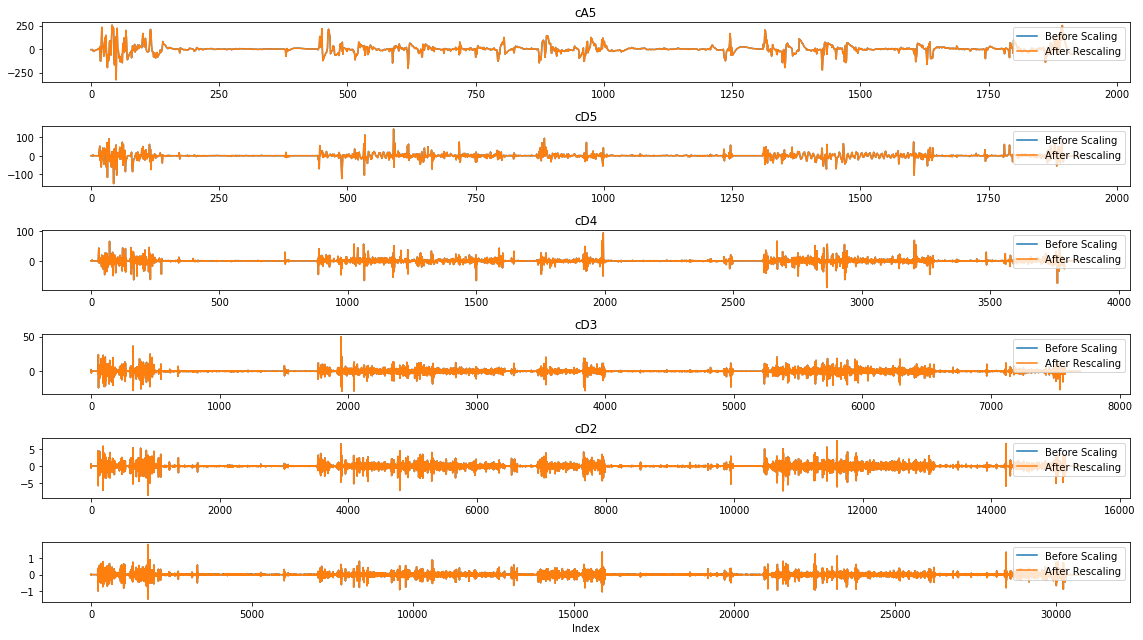

Plot of wavelet coefficients before scaling and after rescaling:


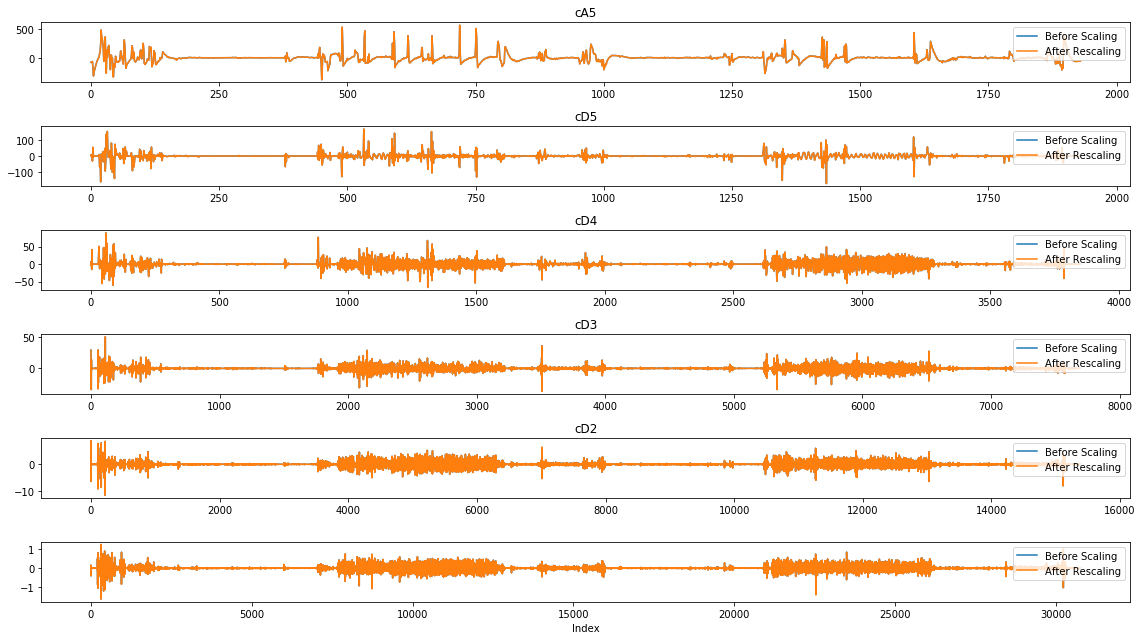

Plot of wavelet coefficients before scaling and after rescaling:


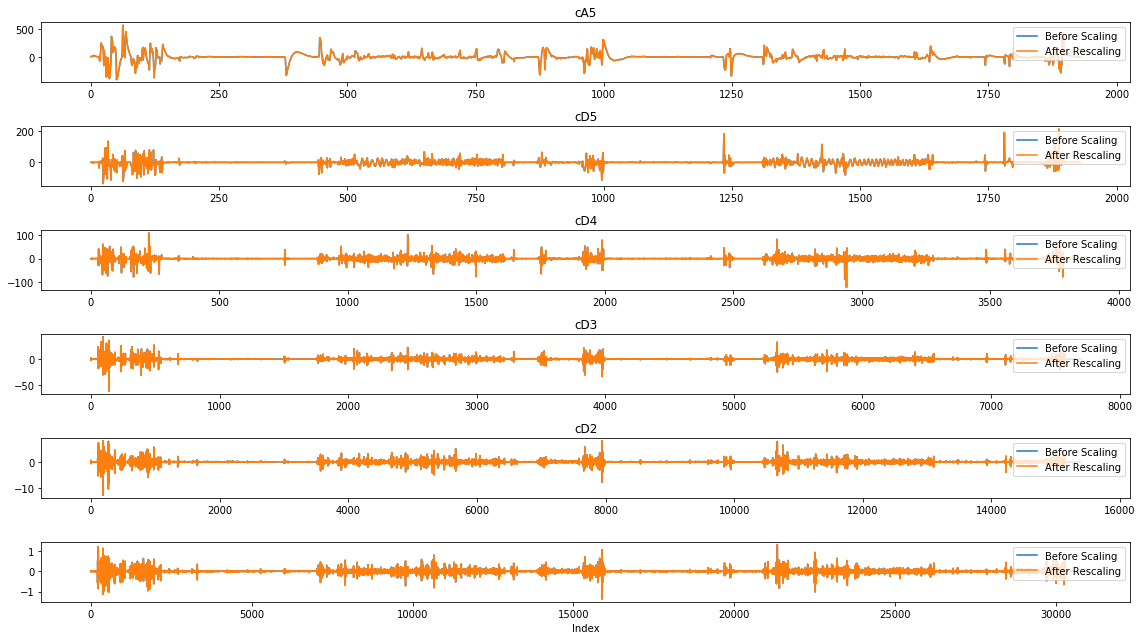

In [57]:
coeffs_unscaled1 = unscale_coeffs(coeffs1, coeffs_reconstructed1, scaling_factors_recovered1, num_bits_recovered1, do_plot)
coeffs_unscaled2 = unscale_coeffs(coeffs2, coeffs_reconstructed2, scaling_factors_recovered2, num_bits_recovered2, do_plot)
coeffs_unscaled3 = unscale_coeffs(coeffs3, coeffs_reconstructed3, scaling_factors_recovered3, num_bits_recovered3, do_plot)

#### reconstruct the data
wavelet reconstruction of the decompressed signal

Plot of original signal through the process of compression and decompression:


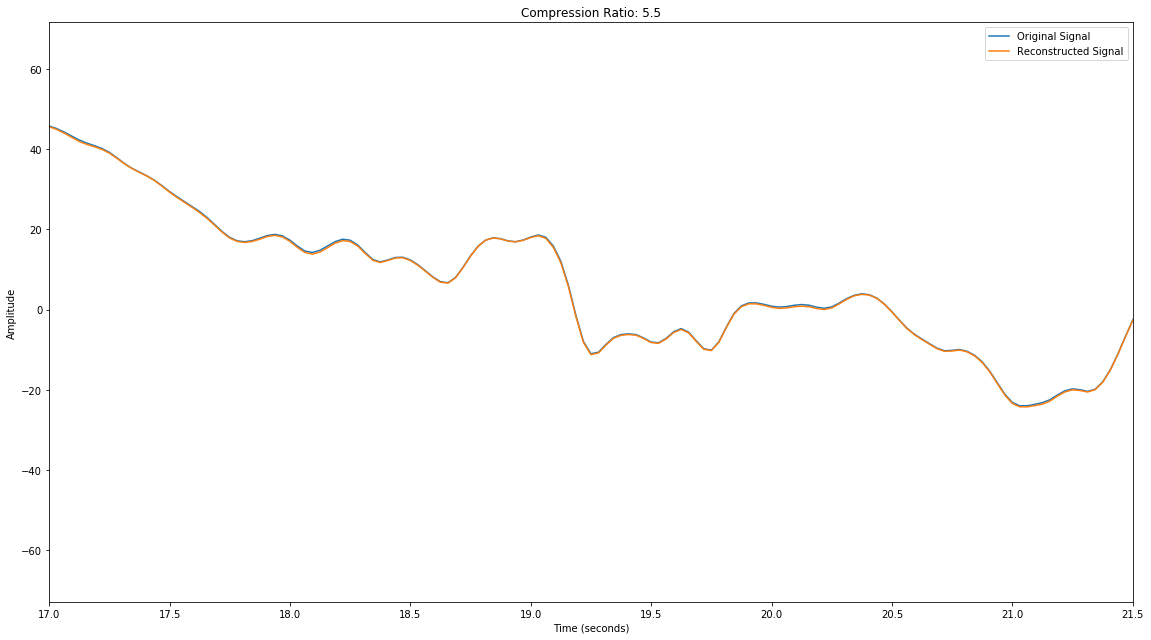

Plot of original signal through the process of compression and decompression:


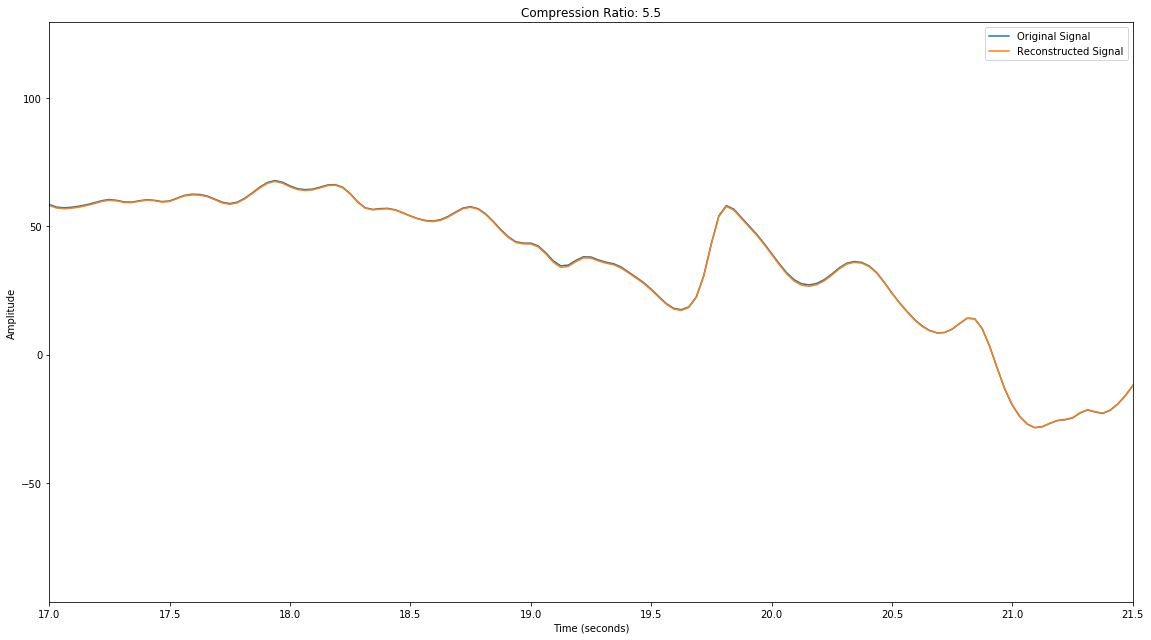

Plot of original signal through the process of compression and decompression:


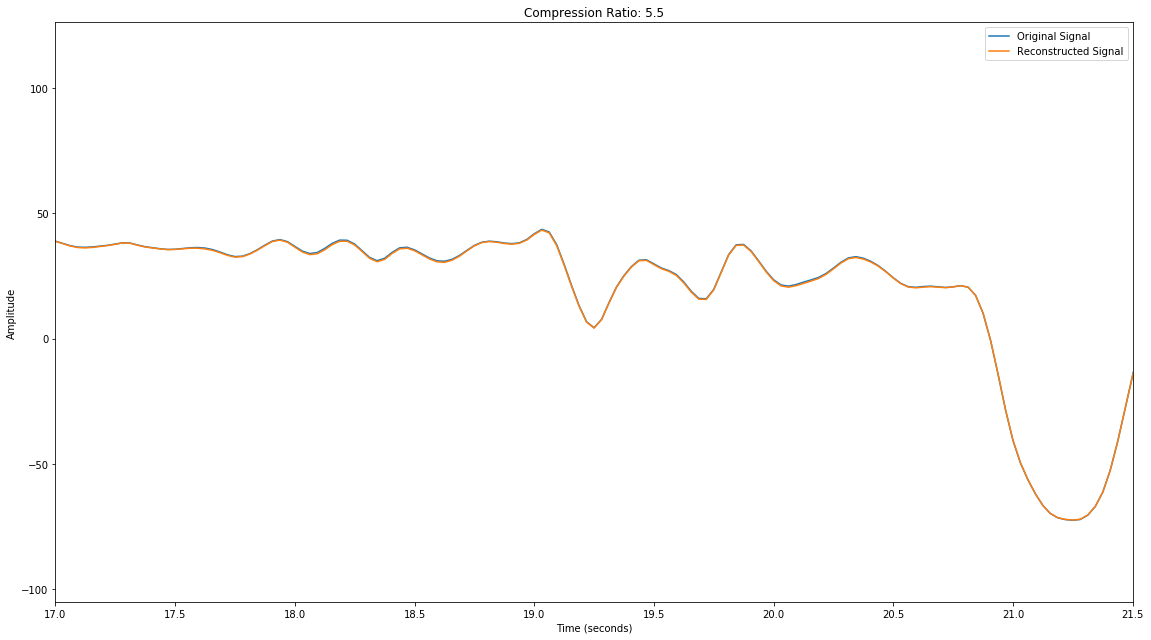

In [58]:
data_reconstructed1 = wavelet_reconstruction(coeffs_unscaled1, data1, 5.519, do_plot)
data_reconstructed2 = wavelet_reconstruction(coeffs_unscaled2, data2, 5.519, do_plot)
data_reconstructed3 = wavelet_reconstruction(coeffs_unscaled3, data3, 5.519, do_plot)

#### plot difference between original and reconstructed signal

Plot of difference between original and reconstructed signal:


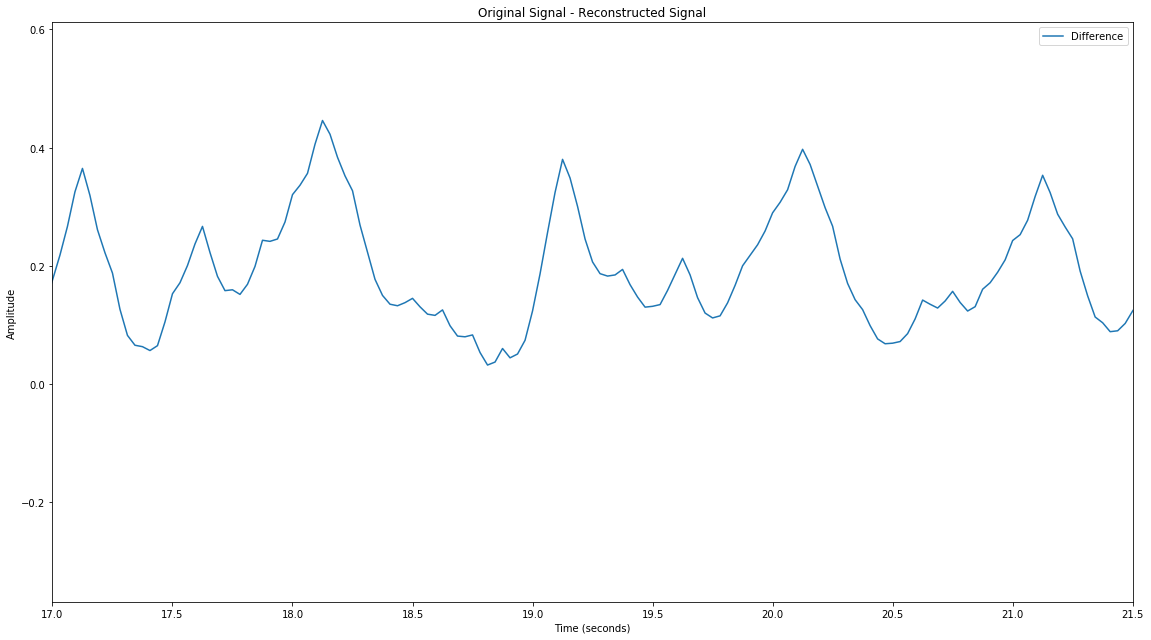

Plot of difference between original and reconstructed signal:


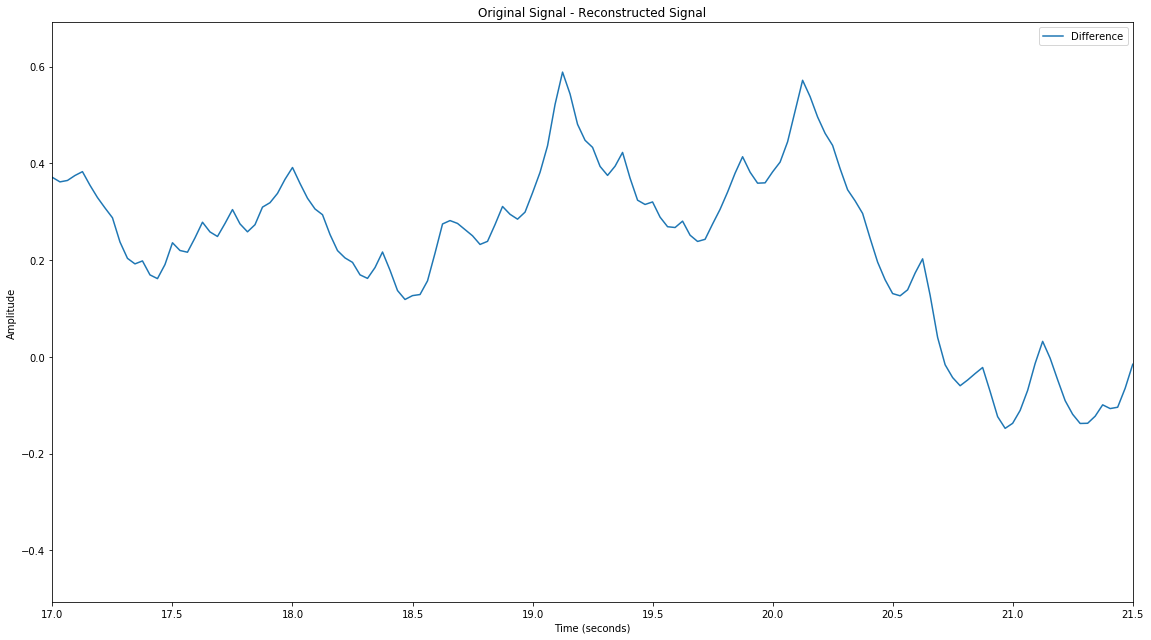

Plot of difference between original and reconstructed signal:


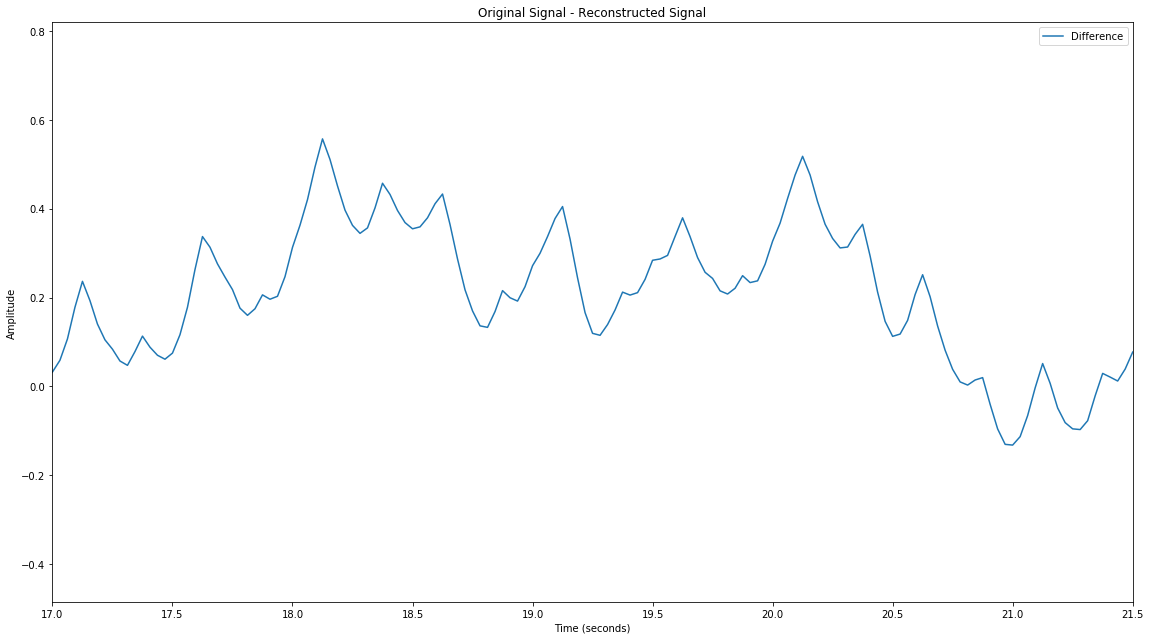

In [59]:
plot_diff(data1, data_reconstructed1)
plot_diff(data2, data_reconstructed2)
plot_diff(data3, data_reconstructed3)

### calculate PRD
Average PRD = 1.428

In [60]:
(calculate_PRD(data1,data_reconstructed1)+calculate_PRD(data2,data_reconstructed2)+calculate_PRD(data3,data_reconstructed3))/3

1.4280210707886845